# Import 

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = fm.FontProperties(fname=font_path).get_name()
rc('font', family=font)

import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression

# Data Import

- input featrue = 27
- 7일간 data를 하나의 instance화 한다면 -> input matrix 7 x 26 -> ouput matrix 7 x 1 (가격만 출력) 
- 2148 row x 26 columns
- 다변량 시계열(multiivariate time series) 예측 system
- In our cousre DA, design for 단변량 시계열(univariate time series) prediction
- 2014.01.01~2020.12.31 data 
- 건고추는 2014.01.22부터, 나머지는 대부분 2014.01.02부터

In [4]:
path = "./Dataset/"
price_tag = ['건고추가격', '대파가격', '마늘가격', '무가격', '배추가격']
crops_en = ['peppers', 'green_onion', 'garlic', 'radish', 'cabbage']

# is zero
isZero = pd.read_csv(path+"da_data.csv")

# no zero 
noZero = pd.read_csv(path+"da_data_nozero.csv")

# new features 
nf_peppers = pd.read_csv(path+"last건고추.csv")
nf_green_onion = pd.read_csv(path+"last대파.csv")
nf_garlic = pd.read_csv(path+"last마늘.csv")
nf_radish = pd.read_csv(path+"last무.csv")
nf_cabbage = pd.read_csv(path+"last배추.csv")

original_data_list = [nf_peppers, nf_green_onion, nf_garlic, nf_radish, nf_cabbage]

In [5]:
X_column_pepper = ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속',
       '최대풍속', '건고추거래량', '건고추생산량', '건고추저장이월량', '건고추수입량', '건고추수입금액',
       '건고추재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세',
       '공공서비스', '개인서비스', '근원물가', '생활물가']
y_column_pepper = ['건고추가격']

X_column_green_onion = ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속',
       '최대풍속', '대파거래량', '대파생산량', '대파저장이월량', '대파수입량', '대파수입금액',
       '대파재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세',
       '공공서비스', '개인서비스', '근원물가', '생활물가']
y_column_green_onion = ['대파가격']

X_column_garlic = ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속',
       '최대풍속', '마늘거래량', '마늘생산량', '마늘저장이월량', '마늘수입량', '마늘수입금액',
       '마늘재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세',
       '공공서비스', '개인서비스', '근원물가', '생활물가']
y_column_garlic = ['마늘가격']

X_column_radish = ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속',
       '최대풍속', '무거래량', '무생산량', '무저장이월량', '무수입량', '무수입금액',
       '무재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세',
       '공공서비스', '개인서비스', '근원물가', '생활물가']
y_column_radish = ['무가격']

X_column_cabbage = ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속',
       '최대풍속', '배추거래량', '배추생산량', '배추저장이월량', '배추수입량', '배추수입금액',
       '배추재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세',
       '공공서비스', '개인서비스', '근원물가', '생활물가']
y_column_cabbage = ['배추가격']

X_column_list = [X_column_pepper, X_column_green_onion, X_column_garlic, X_column_radish, X_column_cabbage]
y_column_list = [y_column_pepper, y_column_green_onion, y_column_garlic, y_column_radish, y_column_cabbage] # oh...is same thing with p-tag...

In [6]:
def pre_processing(data) :
    scaler = MinMaxScaler()
    scale_cols = data.iloc[:,2:].columns
    
    data.sort_index(ascending=False).reset_index(drop=True)
    
    scaled = scaler.fit_transform(data[scale_cols])
    scaled = pd.DataFrame(scaled)
    scaled.columns = scale_cols
    
    return scaled

In [7]:
def gridsearchCV (model, parameters, X_train, y_train) :
    grid = GridSearchCV(model, param_grid = parameters, scoring='accuracy', cv=2) # cv is fold num
    grid.fit(X_train, y_train)
    
    print('GridSearchCV 최적 하이퍼 파라미터 :', grid.best_params_)
    print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid.best_score_))
    print('GridSearchCV 최적 하이퍼 파라미터로 학습된 Esimator 반환')
    
    return grid.best_estimator_


def feature_importance(model_xgb) : 
    fig, ax = plt.subplots(figsize=(10,12))
    plot_importance(model_xgb, ax=ax)

In [8]:
# window_size만큼 데이터를 잘라 이어붙여주는 함수
def make_dataset(data, label, window_size):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)


def make_dataset_split(data, feature_cols, label_cols, window_size) :
    print('feature : ', feature_cols, '\nlabel : ', label_cols)
    feature = data[feature_cols]
    label = data[label_cols]
    
    # WINDOW_SIZE(과거 며칠간의 데이터를 기반으로 예측할 것인지)만큼 데이터셋 분리
    feature, label = make_dataset(feature, label, window_size)
    
    X_train, X_test, Y_train, Y_test = train_test_split(feature, label, test_size=0.2)
    print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
    
    return X_train, X_test, Y_train, Y_test

In [21]:
# For Graph! 
def view_original_price_graph(num) :
    plt.subplot(211)
    plt.plot(original_data_list[num][price_tag[num]])
    plt.subplot(212)
    plt.plot(input_data_list[num][price_tag[num]])
    plt.show()


def view_original_price_hist(num) : 
    plt.hist(original_data_list[num][price_tag[num]])
    plt.title('original price')
    plt.figure()
    plt.hist(input_data_list[num][price_tag[num]])
    plt.title('scaled price')
    plt.figure()
    plt.show()


def graph(pred, test_label) :
    plt.figure(figsize=(16, 9))
    plt.plot(test_label, label = 'actual')
    plt.plot(pred, label = 'prediction')
    plt.legend()
    plt.show()


def plot_history(history):
    #hist = pd.DataFrame(history.history)
    #history['epoch'] = history.epoch
    
    plt.figure(figsize=(8,12))
    
    # Mean Abs Error : 평균 절대 오차, 측정값에서 오차의 크기로 측정값과 실제값과의 차이, 절대 오차의 평균  
    # -> 측정하고자 하는 값을 정확하게 측정하지 못함으로써 발생
    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    plt.legend()
    
    # Mean Square Error : 평균 제곱 오차, 오차의 제복에 대한 평균을 취한 값
    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
    plt.legend()
    plt.show()


# Preproecssing 

input_data_list -> 0:건고추, 1:대파, 2:마늘, 3:무, 4:배추

In [10]:
input_data_list = []
for d in original_data_list : 
    processed = pre_processing(d)
    input_data_list.append(processed)

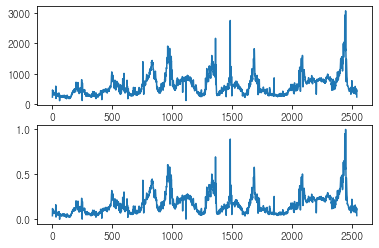

In [23]:
view_original_price_graph(4)

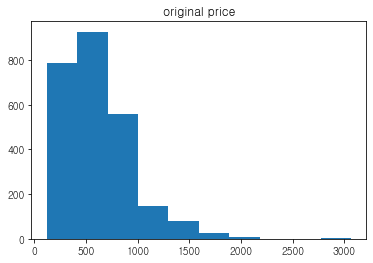

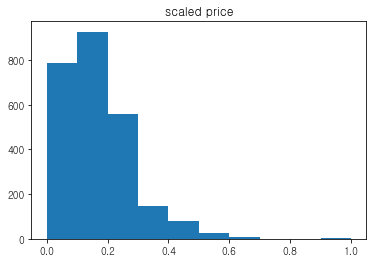

<Figure size 432x288 with 0 Axes>

In [22]:
view_original_price_hist(4)

In [10]:
input_data_list[4]

,평균강수량,최대강수량,평균기온,최고기온,최저기온,평균습도,최저습도,평균풍속,최대풍속,배추가격,...,보통휘발유,자동차용경유,소비자물가지수,농축수산물,공업제품,집세,공공서비스,개인서비스,근원물가,생활물가
0,0.000000,0.000000,0.326034,0.375000,0.306173,0.276923,0.147059,0.181818,0.093607,0.039714,...,0.997506,0.997643,0.517241,0.119816,0.840909,0.896552,0.839080,0.15,0.64,0.340909
1,0.000000,0.000000,0.326034,0.397727,0.281481,0.353846,0.176471,0.090909,0.100457,0.119649,...,0.998987,0.998999,0.517241,0.119816,0.840909,0.896552,0.839080,0.15,0.64,0.340909
2,0.011776,0.080666,0.299270,0.325000,0.291358,0.492308,0.176471,0.204545,0.152968,0.104112,...,0.999719,0.999707,0.517241,0.119816,0.840909,0.896552,0.839080,0.15,0.64,0.340909
3,0.000981,0.078584,0.279805,0.318182,0.269136,0.476923,0.132353,0.181818,0.111872,0.100669,...,0.999922,0.999630,0.517241,0.119816,0.840909,0.896552,0.839080,0.15,0.64,0.340909
4,0.000000,0.028623,0.267640,0.340909,0.234568,0.430769,0.176471,0.068182,0.057078,0.097225,...,0.999969,1.000000,0.517241,0.119816,0.840909,0.896552,0.839080,0.15,0.64,0.340909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2534,0.020608,0.138434,0.340633,0.352273,0.335802,0.707692,0.264706,0.045455,0.159817,0.108616,...,0.248231,0.229243,0.310345,0.824885,0.250000,0.310345,0.528736,0.20,0.32,0.181818
2535,0.000981,0.003643,0.364964,0.438636,0.350617,0.753846,0.323529,0.022727,0.038813,0.104674,...,0.252658,0.234034,0.310345,0.824885,0.250000,0.310345,0.528736,0.20,0.32,0.181818
2536,0.017664,0.017955,0.313869,0.363636,0.303704,0.769231,0.455882,0.227273,0.337900,0.100348,...,0.259110,0.240120,0.310345,0.824885,0.250000,0.310345,0.528736,0.20,0.32,0.181818
2537,0.010795,0.086911,0.097324,0.143182,0.120988,0.384615,0.250000,0.727273,0.509132,0.122982,...,0.264238,0.245420,0.310345,0.824885,0.250000,0.310345,0.528736,0.20,0.32,0.181818


# Modeling 

In [11]:
train_X, test_X, train_y, test_y = make_dataset_split(input_data_list[4], X_column_list[4], y_column_list[4], 7)

feature :  ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속', '최대풍속', '배추거래량', '배추생산량', '배추저장이월량', '배추수입량', '배추수입금액', '배추재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세', '공공서비스', '개인서비스', '근원물가', '생활물가'] 
label :  ['배추가격']
(2025, 7, 26) (2025, 1) (507, 7, 26) (507, 1)


In [12]:
#X_train_see = pd.DataFrame(np.reshape(train_X, (train_X[0], train_X[1])))
#train_X.type()
train_X[0]

array([[0.01472031, 0.15040333, 0.85158151, 0.84772727, 0.84938272,
        0.67692308, 0.44117647, 0.15909091, 0.02739726, 0.17954188,
        0.51476041, 0.        , 0.67289594, 0.50464795, 1.        ,
        0.34162996, 0.30962624, 0.27423157, 0.75862069, 0.70967742,
        0.65909091, 0.68965517, 0.87356322, 0.65      , 0.48      ,
        0.72727273],
       [0.05103042, 0.17538381, 0.84428224, 0.81818182, 0.86419753,
        0.72307692, 0.44117647, 0.13636364, 0.10502283, 0.15341207,
        0.51476041, 0.        , 0.67289594, 0.50464795, 1.        ,
        0.34132894, 0.30767792, 0.27253678, 0.75862069, 0.70967742,
        0.65909091, 0.68965517, 0.87356322, 0.65      , 0.48      ,
        0.72727273],
       [0.00294406, 0.02940411, 0.8783455 , 0.85909091, 0.87407407,
        0.66153846, 0.36764706, 0.18181818, 0.04109589, 0.16600413,
        0.51476041, 0.        , 0.67289594, 0.50464795, 1.        ,
        0.34064768, 0.30630631, 0.27133503, 0.75862069, 0.70967742,
      

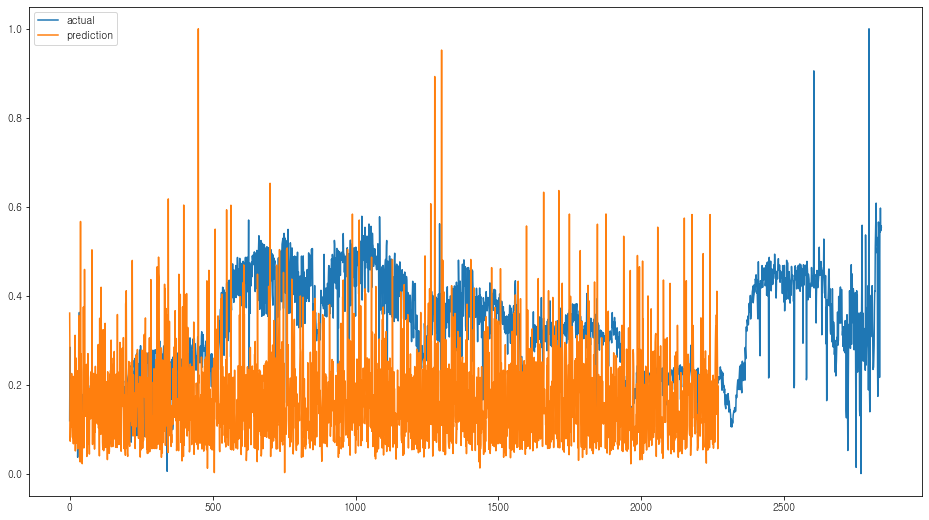

In [21]:
graph(train_y, input_data_list[2][price_tag[2]])

In [13]:
# hyper parameter tuning 
# 7일간의 28개의 featrure를 받아와서 바로 다음 날의 가격(output_dim=1)을 예측 
WINDOW_SIZE = 7 # sequence
DATA_DIM = 26
OUTPUT_DIM = 1
learning_rate = 0.001
EPOCHS = 1000
mini_batch_size = 10
drop_out_value = 0.01
early_stop = EarlyStopping(monitor='val_loss', patience=20) # 조기종료 조건

In [14]:
# layers.Dense(64, activation='relu'),
def build_model_rnn(lr):
    '''
    parameter -> train_dataset 받았었음 
    model_rnn = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(7,26)),
    layers.Dense(1)])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    '''
    
    # rnn 기본 activation function = tanh 
    # input_shape = None 가능, RNN은 어떤 길이의 타입 step도 처리할 수 있기 때문
    model_rnn =keras.Sequential()
    model_rnn.add(layers.SimpleRNN(units=1, activation='tanh', input_shape=[7,26]))
    model_rnn.add(layers.Dense(1))
    
    # 모델 학습 과정 설정 
    model_rnn.compile(loss='mse',
                optimizer=Adam(learning_rate=lr), 
                metrics=['mae', 'mse'])
    
    return model_rnn


model_rnn = build_model_rnn(learning_rate)

# 모델 구성 확인 
model_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 1)                 28        
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________


In [15]:
#history = model_rnn.fit(train_X, train_y, epochs=EPOCHS, validation_split=0.2, verbose =1, batch_size = 10, callbacks=[early_stop])
history = model_rnn.fit(train_X, train_y, epochs=EPOCHS, validation_split=0.2, verbose =1, batch_size = 10)

Epoch 1/1000
162/162 [==============================] - 0s 3ms/step - loss: 0.7438 - mae: 0.7573 - mse: 0.7438 - val_loss: 0.3024 - val_mae: 0.4854 - val_mse: 0.3024
Epoch 2/1000
162/162 [==============================] - 0s 895us/step - loss: 0.2030 - mae: 0.3801 - mse: 0.2030 - val_loss: 0.1401 - val_mae: 0.3084 - val_mse: 0.1401
Epoch 3/1000
162/162 [==============================] - 0s 845us/step - loss: 0.1016 - mae: 0.2596 - mse: 0.1016 - val_loss: 0.0749 - val_mae: 0.2193 - val_mse: 0.0749
Epoch 4/1000
162/162 [==============================] - 0s 838us/step - loss: 0.0602 - mae: 0.1953 - mse: 0.0602 - val_loss: 0.0464 - val_mae: 0.1708 - val_mse: 0.0464
Epoch 5/1000
162/162 [==============================] - 0s 850us/step - loss: 0.0410 - mae: 0.1597 - mse: 0.0410 - val_loss: 0.0353 - val_mae: 0.1517 - val_mse: 0.0353
Epoch 6/1000
162/162 [==============================] - 0s 861us/step - loss: 0.0315 - mae: 0.1386 - mse: 0.0315 - val_loss: 0.0265 - val_mae: 0.1294 - val_mse: 0

162/162 [==============================] - 0s 855us/step - loss: 0.0085 - mae: 0.0656 - mse: 0.0085 - val_loss: 0.0079 - val_mae: 0.0649 - val_mse: 0.0079
Epoch 98/1000
162/162 [==============================] - 0s 865us/step - loss: 0.0084 - mae: 0.0651 - mse: 0.0084 - val_loss: 0.0079 - val_mae: 0.0638 - val_mse: 0.0079
Epoch 99/1000
162/162 [==============================] - 0s 874us/step - loss: 0.0085 - mae: 0.0661 - mse: 0.0085 - val_loss: 0.0078 - val_mae: 0.0628 - val_mse: 0.0078
Epoch 100/1000
162/162 [==============================] - 0s 879us/step - loss: 0.0084 - mae: 0.0659 - mse: 0.0084 - val_loss: 0.0079 - val_mae: 0.0657 - val_mse: 0.0079
Epoch 101/1000
162/162 [==============================] - 0s 851us/step - loss: 0.0085 - mae: 0.0659 - mse: 0.0085 - val_loss: 0.0078 - val_mae: 0.0648 - val_mse: 0.0078
Epoch 102/1000
162/162 [==============================] - 0s 866us/step - loss: 0.0084 - mae: 0.0659 - mse: 0.0084 - val_loss: 0.0078 - val_mae: 0.0639 - val_mse: 0.00

162/162 [==============================] - 0s 869us/step - loss: 0.0082 - mae: 0.0641 - mse: 0.0082 - val_loss: 0.0077 - val_mae: 0.0645 - val_mse: 0.0077
Epoch 194/1000
162/162 [==============================] - 0s 840us/step - loss: 0.0082 - mae: 0.0648 - mse: 0.0082 - val_loss: 0.0077 - val_mae: 0.0627 - val_mse: 0.0077
Epoch 195/1000
162/162 [==============================] - 0s 854us/step - loss: 0.0083 - mae: 0.0651 - mse: 0.0083 - val_loss: 0.0076 - val_mae: 0.0613 - val_mse: 0.0076
Epoch 196/1000
162/162 [==============================] - 0s 849us/step - loss: 0.0083 - mae: 0.0645 - mse: 0.0083 - val_loss: 0.0076 - val_mae: 0.0640 - val_mse: 0.0076
Epoch 197/1000
162/162 [==============================] - 0s 853us/step - loss: 0.0082 - mae: 0.0642 - mse: 0.0082 - val_loss: 0.0075 - val_mae: 0.0615 - val_mse: 0.0075
Epoch 198/1000
162/162 [==============================] - 0s 859us/step - loss: 0.0083 - mae: 0.0648 - mse: 0.0083 - val_loss: 0.0075 - val_mae: 0.0613 - val_mse: 0.

162/162 [==============================] - 0s 839us/step - loss: 0.0080 - mae: 0.0631 - mse: 0.0080 - val_loss: 0.0074 - val_mae: 0.0608 - val_mse: 0.0074
Epoch 290/1000
162/162 [==============================] - 0s 843us/step - loss: 0.0079 - mae: 0.0626 - mse: 0.0079 - val_loss: 0.0077 - val_mae: 0.0659 - val_mse: 0.0077
Epoch 291/1000
162/162 [==============================] - 0s 838us/step - loss: 0.0080 - mae: 0.0635 - mse: 0.0080 - val_loss: 0.0076 - val_mae: 0.0647 - val_mse: 0.0076
Epoch 292/1000
162/162 [==============================] - 0s 844us/step - loss: 0.0080 - mae: 0.0633 - mse: 0.0080 - val_loss: 0.0074 - val_mae: 0.0619 - val_mse: 0.0074
Epoch 293/1000
162/162 [==============================] - 0s 850us/step - loss: 0.0080 - mae: 0.0630 - mse: 0.0080 - val_loss: 0.0075 - val_mae: 0.0622 - val_mse: 0.0075
Epoch 294/1000
162/162 [==============================] - 0s 848us/step - loss: 0.0081 - mae: 0.0635 - mse: 0.0081 - val_loss: 0.0075 - val_mae: 0.0614 - val_mse: 0.

162/162 [==============================] - 0s 849us/step - loss: 0.0068 - mae: 0.0601 - mse: 0.0068 - val_loss: 0.0068 - val_mae: 0.0597 - val_mse: 0.0068
Epoch 386/1000
162/162 [==============================] - 0s 846us/step - loss: 0.0069 - mae: 0.0608 - mse: 0.0069 - val_loss: 0.0071 - val_mae: 0.0622 - val_mse: 0.0071
Epoch 387/1000
162/162 [==============================] - 0s 842us/step - loss: 0.0067 - mae: 0.0600 - mse: 0.0067 - val_loss: 0.0069 - val_mae: 0.0605 - val_mse: 0.0069
Epoch 388/1000
162/162 [==============================] - 0s 844us/step - loss: 0.0066 - mae: 0.0592 - mse: 0.0066 - val_loss: 0.0069 - val_mae: 0.0611 - val_mse: 0.0069
Epoch 389/1000
162/162 [==============================] - 0s 841us/step - loss: 0.0068 - mae: 0.0602 - mse: 0.0068 - val_loss: 0.0073 - val_mae: 0.0613 - val_mse: 0.0073
Epoch 390/1000
162/162 [==============================] - 0s 835us/step - loss: 0.0068 - mae: 0.0605 - mse: 0.0068 - val_loss: 0.0069 - val_mae: 0.0608 - val_mse: 0.

162/162 [==============================] - 0s 852us/step - loss: 0.0065 - mae: 0.0596 - mse: 0.0065 - val_loss: 0.0069 - val_mae: 0.0615 - val_mse: 0.0069
Epoch 482/1000
162/162 [==============================] - 0s 861us/step - loss: 0.0066 - mae: 0.0605 - mse: 0.0066 - val_loss: 0.0076 - val_mae: 0.0682 - val_mse: 0.0076
Epoch 483/1000
162/162 [==============================] - 0s 852us/step - loss: 0.0064 - mae: 0.0595 - mse: 0.0064 - val_loss: 0.0066 - val_mae: 0.0609 - val_mse: 0.0066
Epoch 484/1000
162/162 [==============================] - 0s 865us/step - loss: 0.0064 - mae: 0.0592 - mse: 0.0064 - val_loss: 0.0067 - val_mae: 0.0603 - val_mse: 0.0067
Epoch 485/1000
162/162 [==============================] - 0s 839us/step - loss: 0.0064 - mae: 0.0595 - mse: 0.0064 - val_loss: 0.0070 - val_mae: 0.0630 - val_mse: 0.0070
Epoch 486/1000
162/162 [==============================] - 0s 841us/step - loss: 0.0064 - mae: 0.0594 - mse: 0.0064 - val_loss: 0.0068 - val_mae: 0.0592 - val_mse: 0.

162/162 [==============================] - 0s 854us/step - loss: 0.0064 - mae: 0.0600 - mse: 0.0064 - val_loss: 0.0070 - val_mae: 0.0629 - val_mse: 0.0070
Epoch 578/1000
162/162 [==============================] - 0s 861us/step - loss: 0.0063 - mae: 0.0591 - mse: 0.0063 - val_loss: 0.0071 - val_mae: 0.0627 - val_mse: 0.0071
Epoch 579/1000
162/162 [==============================] - 0s 847us/step - loss: 0.0064 - mae: 0.0590 - mse: 0.0064 - val_loss: 0.0076 - val_mae: 0.0659 - val_mse: 0.0076
Epoch 580/1000
162/162 [==============================] - 0s 867us/step - loss: 0.0065 - mae: 0.0594 - mse: 0.0065 - val_loss: 0.0068 - val_mae: 0.0606 - val_mse: 0.0068
Epoch 581/1000
162/162 [==============================] - 0s 846us/step - loss: 0.0063 - mae: 0.0588 - mse: 0.0063 - val_loss: 0.0066 - val_mae: 0.0606 - val_mse: 0.0066
Epoch 582/1000
162/162 [==============================] - 0s 856us/step - loss: 0.0063 - mae: 0.0590 - mse: 0.0063 - val_loss: 0.0066 - val_mae: 0.0612 - val_mse: 0.

162/162 [==============================] - 0s 837us/step - loss: 0.0064 - mae: 0.0592 - mse: 0.0064 - val_loss: 0.0072 - val_mae: 0.0643 - val_mse: 0.0072
Epoch 674/1000
162/162 [==============================] - 0s 845us/step - loss: 0.0064 - mae: 0.0594 - mse: 0.0064 - val_loss: 0.0066 - val_mae: 0.0611 - val_mse: 0.0066
Epoch 675/1000
162/162 [==============================] - 0s 850us/step - loss: 0.0064 - mae: 0.0595 - mse: 0.0064 - val_loss: 0.0068 - val_mae: 0.0603 - val_mse: 0.0068
Epoch 676/1000
162/162 [==============================] - 0s 865us/step - loss: 0.0064 - mae: 0.0589 - mse: 0.0064 - val_loss: 0.0066 - val_mae: 0.0599 - val_mse: 0.0066
Epoch 677/1000
162/162 [==============================] - 0s 862us/step - loss: 0.0063 - mae: 0.0586 - mse: 0.0063 - val_loss: 0.0066 - val_mae: 0.0609 - val_mse: 0.0066
Epoch 678/1000
162/162 [==============================] - 0s 861us/step - loss: 0.0063 - mae: 0.0589 - mse: 0.0063 - val_loss: 0.0067 - val_mae: 0.0612 - val_mse: 0.

162/162 [==============================] - 0s 849us/step - loss: 0.0063 - mae: 0.0590 - mse: 0.0063 - val_loss: 0.0069 - val_mae: 0.0615 - val_mse: 0.0069
Epoch 770/1000
162/162 [==============================] - 0s 840us/step - loss: 0.0064 - mae: 0.0588 - mse: 0.0064 - val_loss: 0.0067 - val_mae: 0.0622 - val_mse: 0.0067
Epoch 771/1000
162/162 [==============================] - 0s 830us/step - loss: 0.0063 - mae: 0.0595 - mse: 0.0063 - val_loss: 0.0067 - val_mae: 0.0603 - val_mse: 0.0067
Epoch 772/1000
162/162 [==============================] - 0s 845us/step - loss: 0.0063 - mae: 0.0590 - mse: 0.0063 - val_loss: 0.0066 - val_mae: 0.0605 - val_mse: 0.0066
Epoch 773/1000
162/162 [==============================] - 0s 829us/step - loss: 0.0063 - mae: 0.0588 - mse: 0.0063 - val_loss: 0.0068 - val_mae: 0.0613 - val_mse: 0.0068
Epoch 774/1000
162/162 [==============================] - 0s 865us/step - loss: 0.0063 - mae: 0.0589 - mse: 0.0063 - val_loss: 0.0071 - val_mae: 0.0643 - val_mse: 0.

162/162 [==============================] - 0s 858us/step - loss: 0.0063 - mae: 0.0591 - mse: 0.0063 - val_loss: 0.0074 - val_mae: 0.0650 - val_mse: 0.0074
Epoch 866/1000
162/162 [==============================] - 0s 814us/step - loss: 0.0063 - mae: 0.0589 - mse: 0.0063 - val_loss: 0.0066 - val_mae: 0.0596 - val_mse: 0.0066
Epoch 867/1000
162/162 [==============================] - 0s 837us/step - loss: 0.0063 - mae: 0.0588 - mse: 0.0063 - val_loss: 0.0065 - val_mae: 0.0600 - val_mse: 0.0065
Epoch 868/1000
162/162 [==============================] - 0s 855us/step - loss: 0.0063 - mae: 0.0588 - mse: 0.0063 - val_loss: 0.0068 - val_mae: 0.0593 - val_mse: 0.0068
Epoch 869/1000
162/162 [==============================] - 0s 830us/step - loss: 0.0063 - mae: 0.0588 - mse: 0.0063 - val_loss: 0.0074 - val_mae: 0.0637 - val_mse: 0.0074
Epoch 870/1000
162/162 [==============================] - 0s 823us/step - loss: 0.0063 - mae: 0.0588 - mse: 0.0063 - val_loss: 0.0072 - val_mae: 0.0639 - val_mse: 0.

162/162 [==============================] - 0s 890us/step - loss: 0.0063 - mae: 0.0587 - mse: 0.0063 - val_loss: 0.0075 - val_mae: 0.0657 - val_mse: 0.0075
Epoch 962/1000
162/162 [==============================] - 0s 865us/step - loss: 0.0063 - mae: 0.0594 - mse: 0.0063 - val_loss: 0.0067 - val_mae: 0.0592 - val_mse: 0.0067
Epoch 963/1000
162/162 [==============================] - 0s 969us/step - loss: 0.0063 - mae: 0.0586 - mse: 0.0063 - val_loss: 0.0067 - val_mae: 0.0594 - val_mse: 0.0067
Epoch 964/1000
162/162 [==============================] - 0s 842us/step - loss: 0.0062 - mae: 0.0584 - mse: 0.0062 - val_loss: 0.0066 - val_mae: 0.0607 - val_mse: 0.0066
Epoch 965/1000
162/162 [==============================] - 0s 868us/step - loss: 0.0064 - mae: 0.0592 - mse: 0.0064 - val_loss: 0.0074 - val_mae: 0.0663 - val_mse: 0.0074
Epoch 966/1000
162/162 [==============================] - 0s 909us/step - loss: 0.0063 - mae: 0.0592 - mse: 0.0063 - val_loss: 0.0070 - val_mae: 0.0617 - val_mse: 0.

In [16]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,0.743776,0.757341,0.743776,0.302449,0.485390,0.302449,0
1,0.203000,0.380102,0.203000,0.140094,0.308415,0.140094,1
2,0.101640,0.259574,0.101640,0.074947,0.219286,0.074947,2
3,0.060192,0.195273,0.060192,0.046431,0.170759,0.046431,3
4,0.040995,0.159737,0.040995,0.035273,0.151697,0.035273,4
...,...,...,...,...,...,...,...
995,0.006288,0.059221,0.006288,0.007151,0.063211,0.007151,995
996,0.006248,0.058523,0.006248,0.007053,0.063972,0.007053,996
997,0.006258,0.058915,0.006258,0.006548,0.059416,0.006548,997
998,0.006235,0.058662,0.006235,0.006733,0.061007,0.006733,998


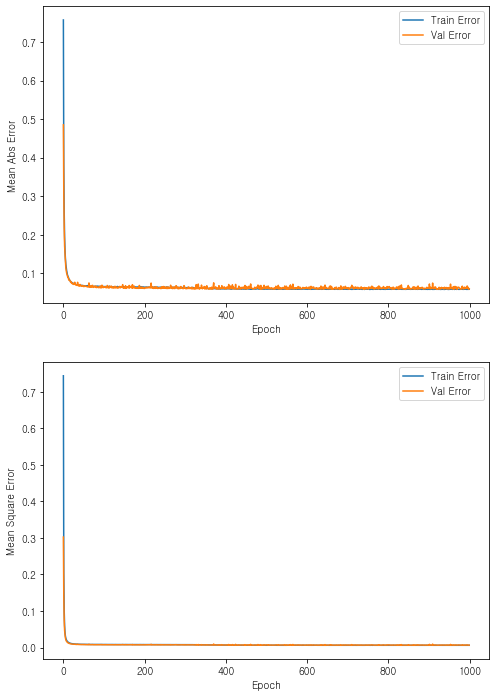

In [17]:
# early stop 빼고 그리기 
plot_history(hist)

In [18]:
# test set data를 통해 모델이 실전에 투입되었을 때 모델의 성능을 예측
loss, mae, mse = model_rnn.evaluate(test_X, test_y, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f}".format(mae))

16/16 - 0s - loss: 0.0061 - mae: 0.0585 - mse: 0.0061
테스트 세트의 평균 절대 오차:  0.06


In [20]:
pred_rnn = model_rnn.predict(test_X) #.flatten()

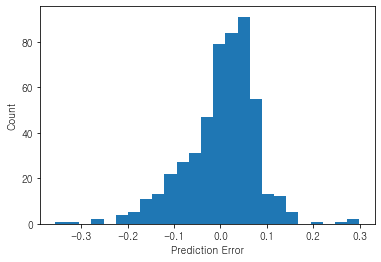

In [21]:
error = pred_rnn - test_y
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

In [22]:
df_result = pd.DataFrame(list(zip(test_y, pred_rnn)), columns=['true_y', 'rnn_pred_y'])
df_result 

,true_y,rnn_pred_y
0,[0.17171146523660882],[0.25531325]
1,[0.28312961456761765],[0.111135736]
2,[0.053262121820830045],[0.11804257]
3,[0.2715714327709912],[0.2233754]
4,[0.09636565757145618],[0.11556369]
...,...,...
502,[0.39922531198073286],[0.4705448]
503,[0.20786609266177766],[0.108297676]
504,[0.11710522232570661],[0.11595051]
505,[0.2717015144778375],[0.20350446]


In [23]:
# rmse
mse = mean_squared_error(test_y, pred_rnn)
print("mse:  %f" % mse)

rmse = np.sqrt(mse)
print("rmse: %f" %rmse)

mse:  0.006095
rmse: 0.078072


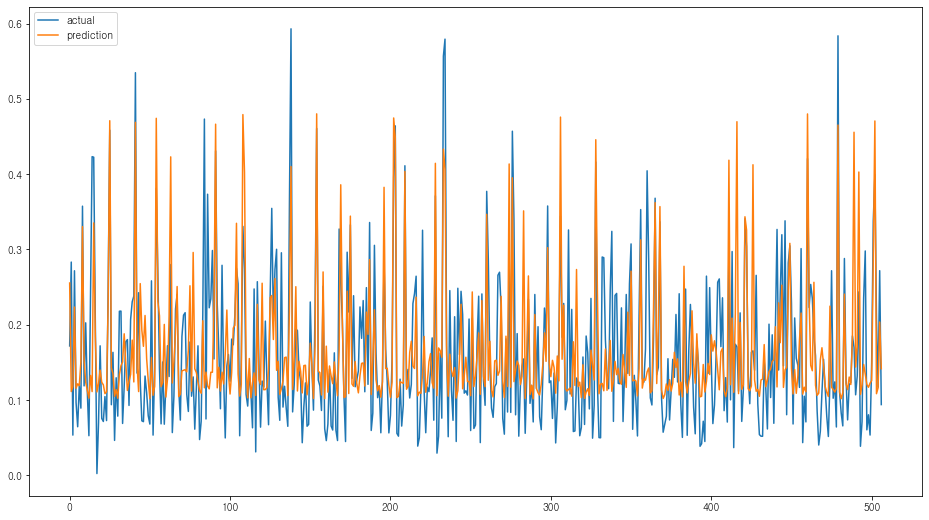

In [24]:
#true_y=test_y.to_numpy()

graph(pred_rnn, test_y)